# Introduction

**Main Topic**

This notebook will simply plug-in [SAM Optimizer](https://github.com/google-research/sam) from [pytorch baseline](https://www.kaggle.com/khyeh0719/pytorch-efficientnet-baseline-train-amp-aug) written by [@khyeh0719](https://www.kaggle.com/khyeh0719).

It increased Baseline LB score from 0.896 -> 0.9. but I used epoch [7, 8, 9, 19] instead of original configs [6, 7, 8, 9]. so It's a bit hard to compare on it but you guys easly can test plug-in SAM Optimizer on your models.

most of code below is same from original baseline, I just added SAM optimizer from on it. so if you want to check SAM Optimizer part, just click Define-SAM-Optimizer part of notebook contents.

And [github source](https://github.com/davda54/sam) which i refer is not offical implement so maybe there is error to implement. Let me know about it.



**References**

[**Sharpness-Aware Minimization for Efficiently Improving Generalization**](https://arxiv.org/abs/2010.01412)

[**Sharpness-Aware Minimization for Efficiently Improving Generalization in Pytorch**](https://github.com/davda54/sam)

[**Pytorch Efficientnet Baseline [Train] AMP+Aug**](https://www.kaggle.com/khyeh0719/pytorch-efficientnet-baseline-train-amp-aug)

## SAM Optimizer

Sharpness-Aware Minimization simultaneously minimizes loss value and loss sharpness. In particular, it seeks parameters that lie in neighborhoods having uniformly low loss. SAM improves model generalization and yields SoTA performance for several datasets. Additionally, it provides robustness to label noise on par with that provided by [SoTA procedures](https://paperswithcode.com/paper/sharpness-aware-minimization-for-efficiently-1) that specifically target learning with noisy labels.

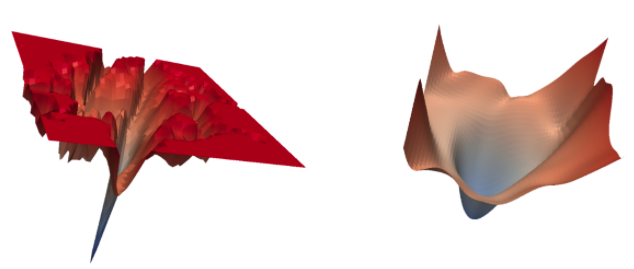

ResNet loss landscape at the end of training with and without SAM. Sharpness-aware updates lead to a significantly wider minimum, which then leads to better generalization properties.




EffNet with SAM Optimizer achieved SoTA on most of cImage Classification Tasks. So we can try to plug-in this optimizer with our on model.

In [ ]:
package_paths = [
    '../input/pytorch-image-models/pytorch-image-models-master', #'../input/efficientnet-pytorch-07/efficientnet_pytorch-0.7.0'
    '../input/image-fmix/FMix-master'
]
import sys; 

for pth in package_paths:
    sys.path.append(pth)
    
from fmix import sample_mask, make_low_freq_image, binarise_mask

In [ ]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

import timm

import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
import cv2
import pydicom
#from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom

In [ ]:
CFG = {
    'fold_num': 5,
    'seed': 719,
    'model_arch': 'tf_efficientnet_b4_ns',
    'img_size': 512,
    'epochs': 10,
    'train_bs': 16,
    'valid_bs': 32,
    'T_0': 10,
    'lr': 1e-4,
    'min_lr': 1e-6,
    'weight_decay':1e-6,
    'num_workers': 4,
    'accum_iter': 2, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'verbose_step': 1,
    'device': 'cuda:0'
}

In [ ]:
train = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
train.head()

In [ ]:
train.label.value_counts()

> We could do stratified validation split in each fold to make each fold's train and validation set looks like the whole train set in target distributions.

In [ ]:
submission = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')
submission.head()

# Helper Functions

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    #print(im_rgb)
    return im_rgb

img = get_img('../input/cassava-leaf-disease-classification/train_images/1000015157.jpg')
plt.imshow(img)
plt.show()

# Dataset

In [ ]:
def rand_bbox(size, lam):
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


class CassavaDataset(Dataset):
    def __init__(self, df, data_root, 
                 transforms=None, 
                 output_label=True, 
                 one_hot_label=False,
                 do_fmix=False, 
                 fmix_params={
                     'alpha': 1., 
                     'decay_power': 3., 
                     'shape': (CFG['img_size'], CFG['img_size']),
                     'max_soft': True, 
                     'reformulate': False
                 },
                 do_cutmix=False,
                 cutmix_params={
                     'alpha': 1,
                 }
                ):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        self.do_fmix = do_fmix
        self.fmix_params = fmix_params
        self.do_cutmix = do_cutmix
        self.cutmix_params = cutmix_params
        
        self.output_label = output_label
        self.one_hot_label = one_hot_label
        
        if output_label == True:
            self.labels = self.df['label'].values
            #print(self.labels)
            
            if one_hot_label is True:
                self.labels = np.eye(self.df['label'].max()+1)[self.labels]
                #print(self.labels)
            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.labels[index]
          
        img  = get_img("{}/{}".format(self.data_root, self.df.loc[index]['image_id']))

        if self.transforms:
            img = self.transforms(image=img)['image']
        
        if self.do_fmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            with torch.no_grad():
                #lam, mask = sample_mask(**self.fmix_params)
                
                lam = np.clip(np.random.beta(self.fmix_params['alpha'], self.fmix_params['alpha']),0.6,0.7)
                
                # Make mask, get mean / std
                mask = make_low_freq_image(self.fmix_params['decay_power'], self.fmix_params['shape'])
                mask = binarise_mask(mask, lam, self.fmix_params['shape'], self.fmix_params['max_soft'])
    
                fmix_ix = np.random.choice(self.df.index, size=1)[0]
                fmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[fmix_ix]['image_id']))

                if self.transforms:
                    fmix_img = self.transforms(image=fmix_img)['image']

                mask_torch = torch.from_numpy(mask)
                
                # mix image
                img = mask_torch*img+(1.-mask_torch)*fmix_img

                #print(mask.shape)

                #assert self.output_label==True and self.one_hot_label==True

                # mix target
                rate = mask.sum()/CFG['img_size']/CFG['img_size']
                target = rate*target + (1.-rate)*self.labels[fmix_ix]
                #print(target, mask, img)
                #assert False
        
        if self.do_cutmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            #print(img.sum(), img.shape)
            with torch.no_grad():
                cmix_ix = np.random.choice(self.df.index, size=1)[0]
                cmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[cmix_ix]['image_id']))
                if self.transforms:
                    cmix_img = self.transforms(image=cmix_img)['image']
                    
                lam = np.clip(np.random.beta(self.cutmix_params['alpha'], self.cutmix_params['alpha']),0.3,0.4)
                bbx1, bby1, bbx2, bby2 = rand_bbox((CFG['img_size'], CFG['img_size']), lam)

                img[:, bbx1:bbx2, bby1:bby2] = cmix_img[:, bbx1:bbx2, bby1:bby2]

                rate = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (CFG['img_size'] * CFG['img_size']))
                target = rate*target + (1.-rate)*self.labels[cmix_ix]
                
            #print('-', img.sum())
            #print(target)
            #assert False
                            
        # do label smoothing
        #print(type(img), type(target))
        if self.output_label == True:
            return img, target
        else:
            return img

# Define Train\Validation Image Augmentations

In [ ]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return Compose([
            RandomResizedCrop(CFG['img_size'], CFG['img_size']),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.)
  
        
def get_valid_transforms():
    return Compose([
            CenterCrop(CFG['img_size'], CFG['img_size'], p=1.),
            Resize(CFG['img_size'], CFG['img_size']),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

# Model

In [ ]:
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)
        '''
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            #nn.Linear(n_features, hidden_size,bias=True), nn.ELU(),
            nn.Linear(n_features, n_class, bias=True)
        )
        '''
    def forward(self, x):
        x = self.model(x)
        return x

# Define SAM Optimizer


original source is [here](https://github.com/davda54/sam/blob/main/sam.py).

After we define SAM Optimizer we just need to modify two part from below Training APIs, Main Loop

- Main Loop : modify Optimizer adam to SAM, we need to call SGD first.
- Training APIs : modify Optimizer with two step.

I'll explan detail in title of Main Loop, Training APIs

In [ ]:
## original source is https://github.com/davda54/sam/blob/main/sam.py

import torch


class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                e_w = p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"
                self.state[p]["e_w"] = e_w

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    def step(self, closure=None):
        raise NotImplementedError("SAM doesn't work like the other optimizers, you should first call `first_step` and the `second_step`; see the documentation for more info.")

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        p.grad.norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

# Training APIs

SAM Optimizer needs two forward-backward passes to estime the "sharpness-aware" gradient. so we need to change opmizer like this code.

    loss = loss_fn(image_preds, image_labels) 
    loss.backward()
    optimizer.first_step(zero_grad=True)

    # second forward-backward pass
    loss_fn(model(imgs), image_labels).backward()
    optimizer.second_step(zero_grad=True)
    
note that I skipped gradients clipping step caues it made a error with SAM Optimizer, you can modify this if you want.

In [ ]:
def prepare_dataloader(df, trn_idx, val_idx, data_root='../input/cassava-leaf-disease-classification/train_images/'):
    
    from catalyst.data.sampler import BalanceClassSampler
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
        
    train_ds = CassavaDataset(train_, data_root, transforms=get_train_transforms(), output_label=True, one_hot_label=False, do_fmix=False, do_cutmix=False)
    valid_ds = CassavaDataset(valid_, data_root, transforms=get_valid_transforms(), output_label=True)
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=False,
        drop_last=False,
        shuffle=True,        
        num_workers=CFG['num_workers'],
        #sampler=BalanceClassSampler(labels=train_['label'].values, mode="downsampling")
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=False,
    )
    return train_loader, val_loader

def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None, schd_batch_update=False):
    model.train()

    t = time.time()
    running_loss = None

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()

        #print(image_labels.shape, exam_label.shape)
        with autocast():
            image_preds = model(imgs)   #output = model(input)
            #print(image_preds.shape, exam_pred.shape)

            loss = loss_fn(image_preds, image_labels) 
            loss.backward()
            optimizer.first_step(zero_grad=True)

            # second forward-backward pass
            loss_fn(model(imgs), image_labels).backward()
            optimizer.second_step(zero_grad=True)
            
            
            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01

#             if ((step + 1) %  CFG['accum_iter'] == 0) or ((step + 1) == len(train_loader)):
#                 # may unscale_ here if desired (e.g., to allow clipping unscaled gradients)

#                 scaler.step(optimizer)
#                 scaler.update()
#                 optimizer.zero_grad() 
                
                if scheduler is not None and schd_batch_update:
                    scheduler.step()

            if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
                description = f'epoch {epoch} loss: {running_loss:.4f}'
                
                pbar.set_description(description)
                
    if scheduler is not None and not schd_batch_update:
        scheduler.step()
        
def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    model.eval()

    t = time.time()
    loss_sum = 0
    sample_num = 0
    image_preds_all = []
    image_targets_all = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        image_preds = model(imgs)   #output = model(input)
        #print(image_preds.shape, exam_pred.shape)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        loss = loss_fn(image_preds, image_labels)
        
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]  

        if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(val_loader)):
            description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
            pbar.set_description(description)
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    print('validation multi-class accuracy = {:.4f}'.format((image_preds_all==image_targets_all).mean()))
    
    if scheduler is not None:
        if schd_loss_update:
            scheduler.step(loss_sum/sample_num)
        else:
            scheduler.step()

In [ ]:
# reference: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/173733
class MyCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean'):
        super().__init__(weight=weight, reduction=reduction)
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        lsm = F.log_softmax(inputs, -1)

        if self.weight is not None:
            lsm = lsm * self.weight.unsqueeze(0)

        loss = -(targets * lsm).sum(-1)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

# Main Loop

simply change optimizer to SAM Optimizer. we need to call SGD as a base_optimizer.

        base_optimizer = torch.optim.SGD
        optimizer = SAM(model.parameters(), base_optimizer, lr=0.1, momentum=0.9)  


In [ ]:
if __name__ == '__main__':
     # for training only, need nightly build pytorch

    seed_everything(CFG['seed'])
    
    folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)
    
    for fold, (trn_idx, val_idx) in enumerate(folds):
        # we'll train fold 0 first
        if fold > 0:
            break 

        print('Training with {} started'.format(fold))

        print(len(trn_idx), len(val_idx))
        train_loader, val_loader = prepare_dataloader(train, trn_idx, val_idx, data_root='../input/cassava-leaf-disease-classification/train_images/')

        device = torch.device(CFG['device'])
        
        model = CassvaImgClassifier(CFG['model_arch'], train.label.nunique(), pretrained=True).to(device)
        scaler = GradScaler() 
        
        base_optimizer = torch.optim.SGD
        optimizer = SAM(model.parameters(), base_optimizer, lr=0.1, momentum=0.9)        
        #optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=CFG['epochs']-1)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CFG['T_0'], T_mult=1, eta_min=CFG['min_lr'], last_epoch=-1)
        #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=25, 
        #                                                max_lr=CFG['lr'], epochs=CFG['epochs'], steps_per_epoch=len(train_loader))
        
        loss_tr = nn.CrossEntropyLoss().to(device) #MyCrossEntropyLoss().to(device)
        loss_fn = nn.CrossEntropyLoss().to(device)
        
        for epoch in range(CFG['epochs']):
            train_one_epoch(epoch, model, loss_tr, optimizer, train_loader, device, scheduler=scheduler, schd_batch_update=False)

            with torch.no_grad():
                valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False)

            torch.save(model.state_dict(),'{}_fold_{}_{}'.format(CFG['model_arch'], fold, epoch))
            
        #torch.save(model.cnn_model.state_dict(),'{}/cnn_model_fold_{}_{}'.format(CFG['model_path'], fold, CFG['tag']))
        del model, optimizer, train_loader, val_loader, scaler, scheduler
        torch.cuda.empty_cache()

# Inferece part is here: https://www.kaggle.com/khyeh0719/pytorch-efficientnet-baseline-inference-tta